In [1]:
import os
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/global/common/software/nersc/cos1.3/cuda/11.3.0'
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from chainconsumer import ChainConsumer
import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin

In [3]:
# Load maps 
kmaps = []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/maps/"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/maps/', filename), 'rb'))
        kmaps.append(res['kmap'])

2022-09-16 07:39:41.223559: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 07:39:42.088228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38280 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [5]:
from flowpm.fourier_smoothing import fourier_smoothing
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10
    pix_scale = field_size / field_npix * 60
    ngal_per_pix = ngal * pix_scale**2
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    return kmap

In [6]:
bins=tf.linspace(-.1, 1.,8)
rangev=[-.1,1.]
pcounts_5_6_7=[]
for i in range(len(kmaps)):
    kmap =desc_y1_analysis(kmaps[i])
    counts_5_6_7,bins_=DHOS.statistics.peaks_histogram_tf_mulscale(kmap,nscales=7,bins=bins)
    counts_5_6_7=counts_5_6_7[4:7]
    pcounts_5_6_7.append(counts_5_6_7)
pcounts_5_6_7=stack(pcounts_5_6_7, axis=0)
pcounts_mean_5_6_7= pcounts_5_6_7.mean(axis=0)

2022-09-16 07:40:27.089989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-16 07:40:28.034906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


In [7]:
pcounts_jac_5_6_7= []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/jac_peakcounts"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/jac_peakcounts', filename), 'rb'))
        pcounts_jac_5_6_7.append(res['jac'])
pcounts_jac_5_6_7=stack(pcounts_jac_5_6_7, axis=0)        
pcounts_jac_5_6_7 = stack(pcounts_jac_5_6_7, axis=0)

In [8]:
# Computing covariance matrix
f_sky=25/150000
cov_pcounts_5=np.cov(tf.reshape(pcounts_5_6_7[:,0,:],[len(pcounts_5_6_7),8]), rowvar=False)*f_sky
cov_pcounts_6=np.cov(tf.reshape(pcounts_5_6_7[:,1,:],[len(pcounts_5_6_7),8]), rowvar=False)*f_sky
cov_pcounts_7=np.cov(tf.reshape(pcounts_5_6_7[:,2,:],[len(pcounts_5_6_7),8]), rowvar=False)*f_sky
fac_pcounts_5=np.sqrt(np.diag(cov_pcounts_5))
fac_pcounts_6=np.sqrt(np.diag(cov_pcounts_6))
fac_pcounts_7=np.sqrt(np.diag(cov_pcounts_7))

In [9]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$","$A_{IA}$"]

# Peak counts scales 5-6-7

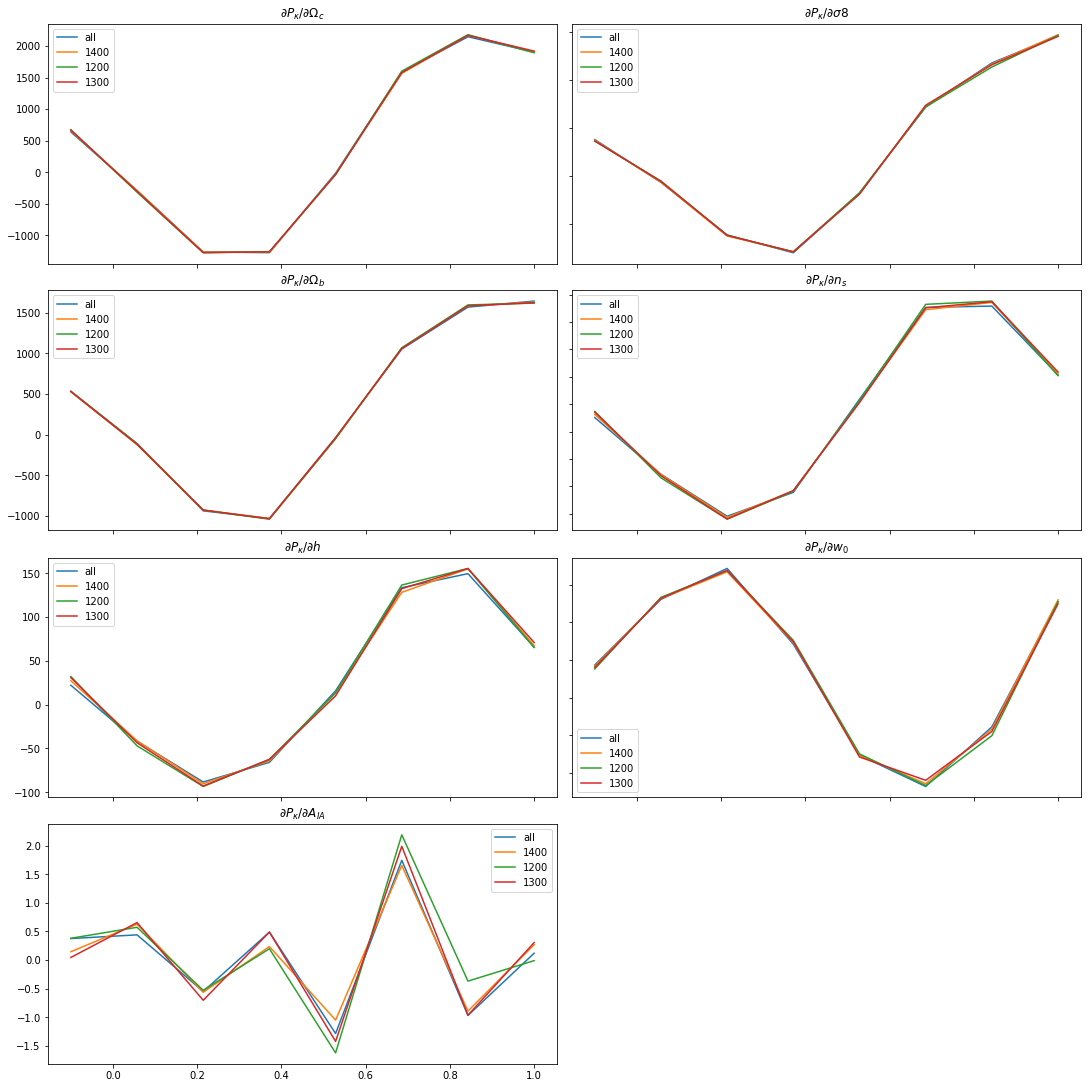

In [10]:
scl=0
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =4
ax = fig.subplots(rows, cols)
for j in range(7):
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_5,label='all')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1400,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_5,label='1400')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1200,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_5,label='1200')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1300,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_5,label='1300')
    ax.flatten()[j].set_title('$\partial P_\kappa/\partial$' +str(labels[j]))
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()
for i in range(7,8):
    ax.flatten()[i].remove()

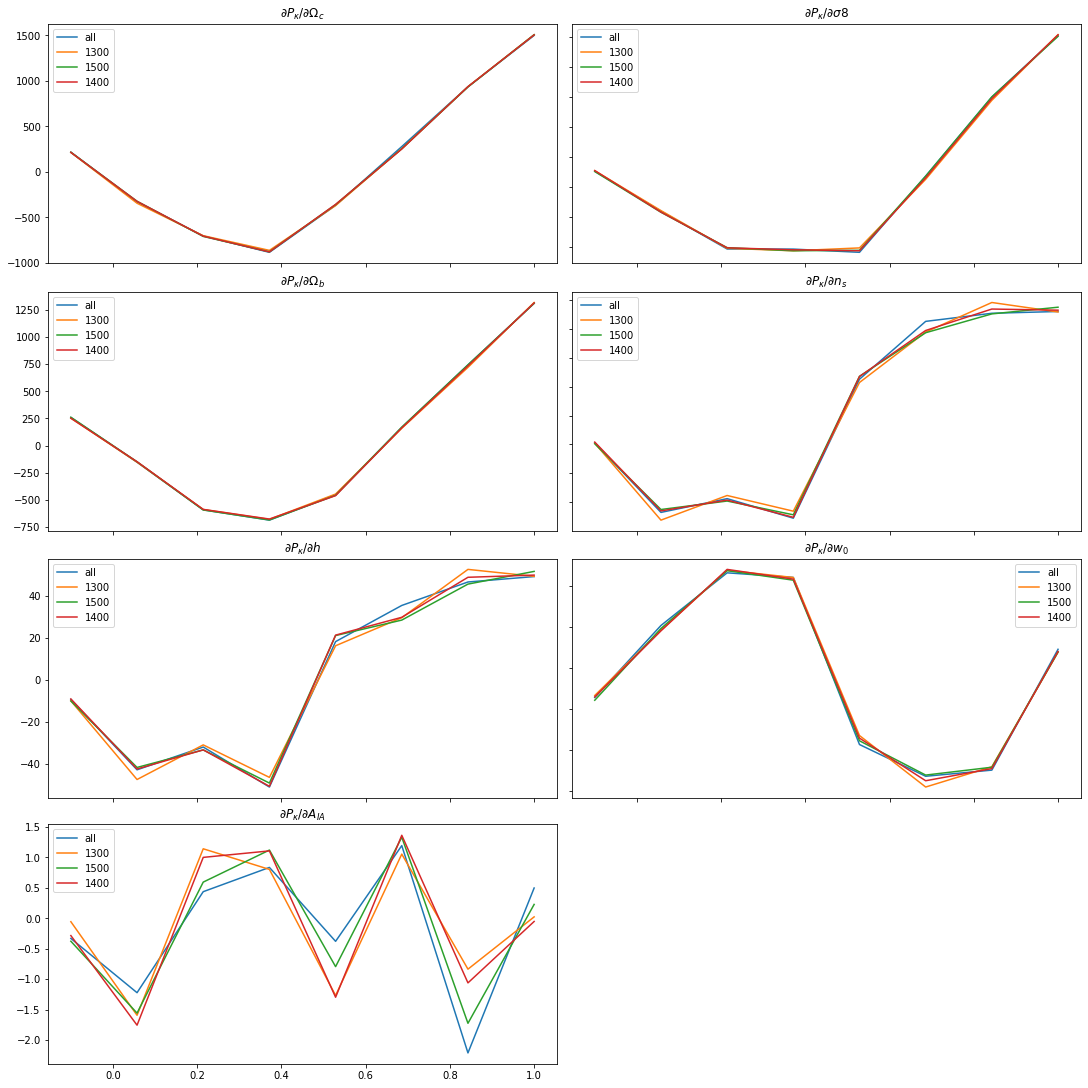

In [11]:
scl=1
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =4
ax = fig.subplots(rows, cols)
for j in range(7):
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_6,label='all')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1300,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_6,label='1300')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1500,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_6,label='1500')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1400,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_6,label='1400')
    ax.flatten()[j].set_title('$\partial P_\kappa/\partial$' +str(labels[j]))
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()
for i in range(7,8):
    ax.flatten()[i].remove()

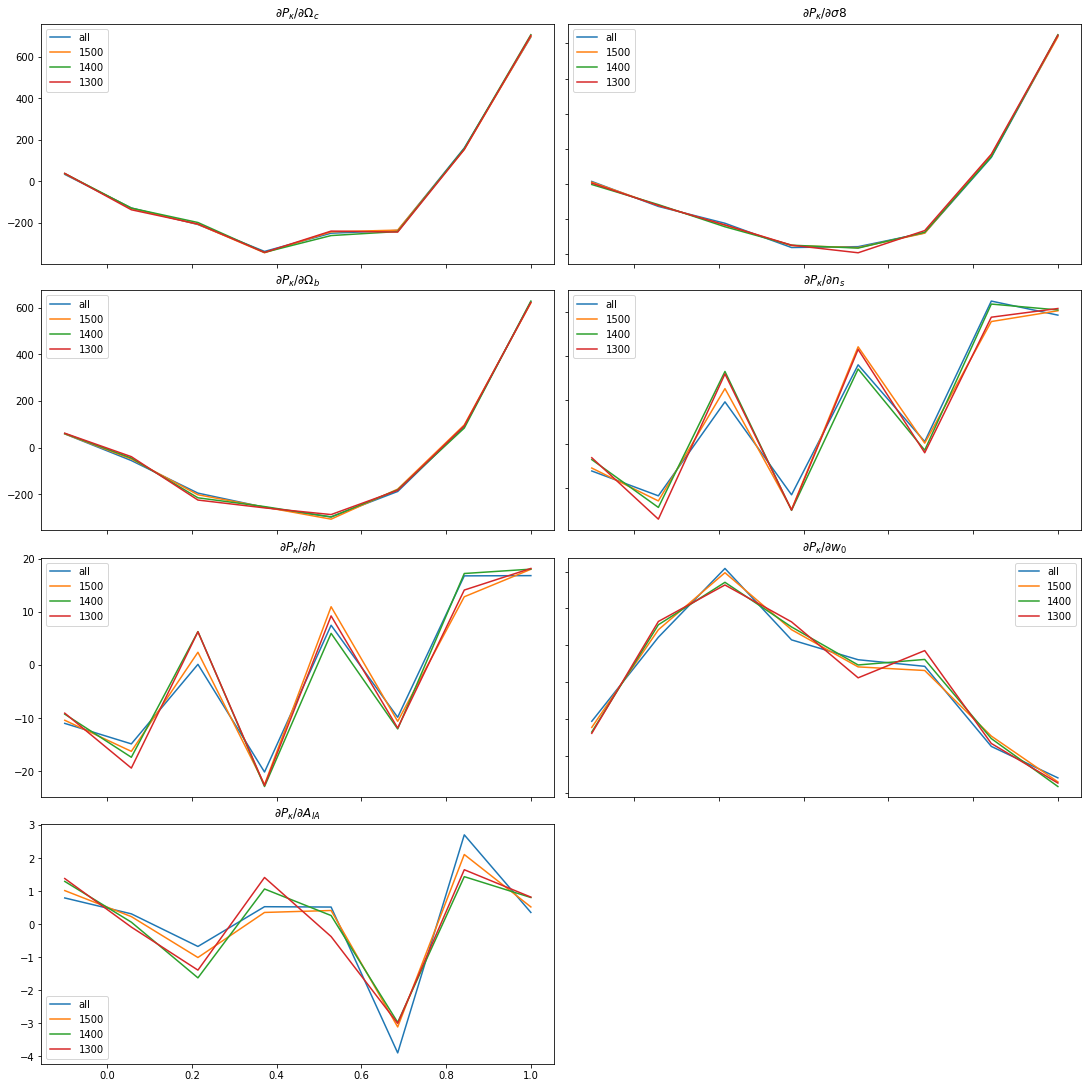

In [12]:
scl=2
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =4
ax = fig.subplots(rows, cols)
for j in range(7):
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_7,label='all')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1500,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_7,label='1500')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1400,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_7,label='1400')
    ax.flatten()[j].plot(bins,pcounts_jac_5_6_7[:1300,scl,:,:].mean(axis=0)[...,j]/fac_pcounts_7,label='1300')
    ax.flatten()[j].set_title('$\partial P_\kappa/\partial$' +str(labels[j]))
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()
for i in range(7,8):
    ax.flatten()[i].remove()


# Validate the stability of the fisher contours

In [13]:
# Computing covariance matrix

cov=np.cov(tf.reshape(pcounts_5_6_7[:,:,:],[len(pcounts_5_6_7),24]), rowvar=False)*f_sky

#1600
dmu = tf.reshape(pcounts_jac_5_6_7[:,:,:,:],[len(pcounts_jac_5_6_7),24,7]).numpy().mean(axis=0)
Fp = dmu.T @ (np.linalg.inv(cov)) @ dmu

#1500
dmu_5 = tf.reshape(pcounts_jac_5_6_7[:1500,:,:,:],[1500,24,7]).numpy().mean(axis=0)
Fp_5 = dmu_5.T @ (np.linalg.inv(cov)) @ dmu_5

#1400
dmu_4 = tf.reshape(pcounts_jac_5_6_7[:1400,:,:,:],[1400,24,7]).numpy().mean(axis=0)
Fp_4 = dmu_4.T @ (np.linalg.inv(cov)) @ dmu_4

#1300
dmu_3 = tf.reshape(pcounts_jac_5_6_7[:1300,:,:,:],[1300,24,7]).numpy().mean(axis=0)
Fp_3 = dmu_3.T @ (np.linalg.inv(cov)) @ dmu_3


#1200
dmu_2 = tf.reshape(pcounts_jac_5_6_7[:1200,:,:,:],[1200,24,7]).numpy().mean(axis=0)
Fp_2 = dmu_2.T @ (np.linalg.inv(cov)) @ dmu_2


#1100
dmu_1 = tf.reshape(pcounts_jac_5_6_7[:1100,:,:,:],[1100,24,7]).numpy().mean(axis=0)
Fp_1 = dmu_1.T @ (np.linalg.inv(cov)) @ dmu_1

#1000
dmu_0 = tf.reshape(pcounts_jac_5_6_7[:1000,:,:,:],[1000,24,7]).numpy().mean(axis=0)
Fp_0 = dmu_0.T @ (np.linalg.inv(cov)) @ dmu_0

In [14]:
fid_params=np.array([0.2589, 0.8159, 0.04860, 0.9667, 0.6774, -1.0, 0. ])

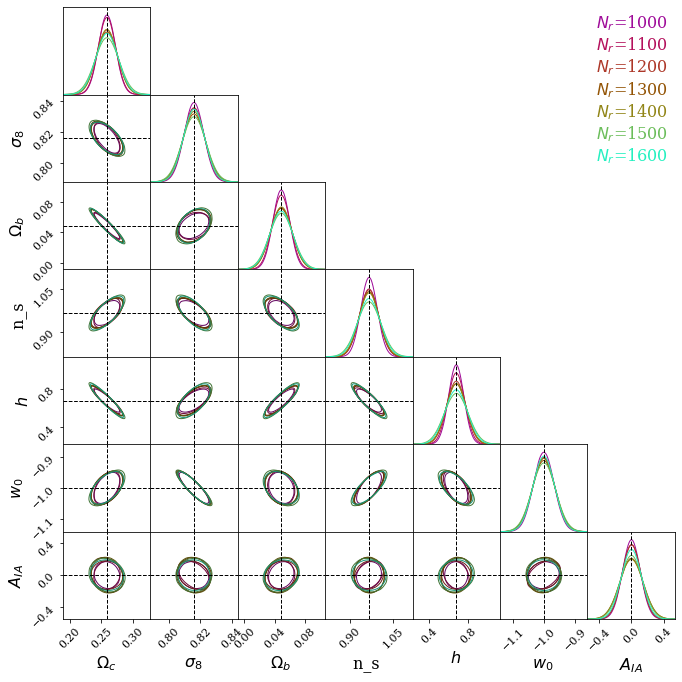

In [15]:
col = cmr.tropical
c = ChainConsumer()
##########
c.add_covariance(fid_params , np.linalg.inv(Fp_0), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1000")
##########
c.add_covariance(fid_params , np.linalg.inv(Fp_1), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1100")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_2), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1200")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_3), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1300")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_4), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1400")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_5), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1500")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1600")

c.configure(usetex=False, max_ticks=3,tick_font_size=11, label_font_size=16,sigmas=[0,1],spacing=0.0,cmap=col)
fig = c.plotter.plot(figsize="column", truth=fid_params)
fig.set_size_inches(5 + fig.get_size_inches())
#plt.savefig('../../figures/Fisher_stability_peak.pdf')
